# Image recognition algorithm: climate regions of streetview panoramas

##### to run this in google colab: git clone the repo and use google drive to save results
##### it is recommended to use a GPU runtime

In [ ]:
!git clone https://github.com/Quibusque/snc_project
!mv snc_project/* .

In [2]:
import os
import tensorflow as tf

from source.training import train_model, build_model, build_dataset
from source.utils import (
    prepare_dataframe_and_files_for_training,
    reset_images_position,
    make_labelled_dataframe,
)
from source.metrics import confusion_matrix, save_class_metrics
from source.plots import confusion_matrix_plot, accuracy_loss_plot

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

##### download the dataset from kaggle. You must use your personal username and key

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets

opendatasets.download(
    "https://www.kaggle.com/datasets/nikitricky/streetview-photospheres"
)

##### setup the directories and csv path (defaults should be correct)

In [6]:
main_dir = "streetview-photospheres"
img_dir = os.path.join(main_dir, "images")
csv_path = os.path.join(main_dir, "images.csv")
bad_img_dir = os.path.join(main_dir, "bad_images")
test_img_dir = os.path.join(main_dir, "test_images")

##### setup the checkpoint directory (here we use google drive)

In [7]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints/"

(optional) reset image file positions if you have already run the code before

In [8]:
reset_images_position(img_dir, bad_img_dir, test_img_dir)

##### create the dataframe with images and labels

In [9]:
df, name_dict = make_labelled_dataframe(csv_path, img_dir)

Computing region label for images, this may take a while...
Done!


##### see what the most populated regions are, to choose those with a large enough number of images

In [6]:
num_entries_to_print = 15
print(df['label'].value_counts().head(num_entries_to_print))

5     29324
17    27283
16    18856
19    17839
4     17502
39    11410
38     9851
3      7336
36     6440
14     5698
6      4144
43     3902
11     3386
18     2830
1      2454
Name: label, dtype: int64


### Multi-MIP Climate Change ATLAS reference regions
###### source: https://github.com/SantanderMetGroup/ATLAS
![Multi-MIP Climate Change ATLAS reference regions](https://raw.githubusercontent.com/SantanderMetGroup/ATLAS/main/reference-regions/reference_regions_names.png)

##### choose your labels (they should have a reasonably high number of entries)

In [11]:
chosen_labels = [5, 17, 16, 19, 4, 39, 38]
num_classes = len(chosen_labels)
label_map = {num: index for index, num in enumerate(chosen_labels)}

##### choose how many images to use for training for each label (excess images will be used later for testing)

In [12]:
samples_per_label = 9000

##### choose some parameters (model name is used for saved files with results)

In [13]:
seed = 42
model_name = "my_model"
# savedir is used to save results
save_dir = os.path.join(checkpoint_dir, "results", model_name)

In [14]:
df_good, df_test = prepare_dataframe_and_files_for_training(
    df,
    chosen_labels,
    img_dir,
    bad_img_dir,
    test_img_dir,
    samples_per_label,
    seed,
)

##### build training, validation and test datasets

In [15]:
tra_ds, val_ds = build_dataset(
    img_dir, df_good, label_map, shuffle=True, seed=seed, validation_split=0.2
)

Found 63000 files belonging to 7 classes.
Using 50400 files for training.
Using 12600 files for validation.


In [16]:
test_ds = build_dataset(
    test_img_dir, df_test, label_map, shuffle=False, seed=None, validation_split=None
)

Found 69065 files belonging to 7 classes.


##### choose parameters for the model (defaults are ok)

In [17]:
metric = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
loss = tf.keras.losses.SparseCategoricalCrossentropy()
dropout_rate = 0.2
epochs = 10
model = build_model(num_classes, metric, loss, dropout_rate)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output (Dense)              (None, 7)                 8967      
                                                                 
Total params: 5928279 (22.61 MB)
Trainable params: 5867671 (22.38 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


##### train the model

In [18]:
history = train_model(
    model,
    tra_ds,
    val_ds,
    epochs,
    model_name,
    checkpoint_dir)

Epoch 1/10
788/788 [==============================] - 465s 516ms/step - loss: 1.9433 - accuracy: 0.3299 - val_loss: 1.6663 - val_accuracy: 0.3714
Epoch 2/10
788/788 [==============================] - 423s 535ms/step - loss: 1.3197 - accuracy: 0.4907 - val_loss: 1.0937 - val_accuracy: 0.5733
Epoch 3/10
788/788 [==============================] - 404s 512ms/step - loss: 1.0608 - accuracy: 0.5917 - val_loss: 0.9532 - val_accuracy: 0.6215
Epoch 4/10
788/788 [==============================] - 420s 533ms/step - loss: 0.9241 - accuracy: 0.6416 - val_loss: 1.0207 - val_accuracy: 0.6112
Epoch 5/10
788/788 [==============================] - 406s 514ms/step - loss: 1.2144 - accuracy: 0.5666 - val_loss: 1.3157 - val_accuracy: 0.4825
Epoch 6/10
788/788 [==============================] - 407s 516ms/step - loss: 1.3911 - accuracy: 0.5132 - val_loss: 1.1294 - val_accuracy: 0.5689


##### plot and save accuracy and loss curves over epochs

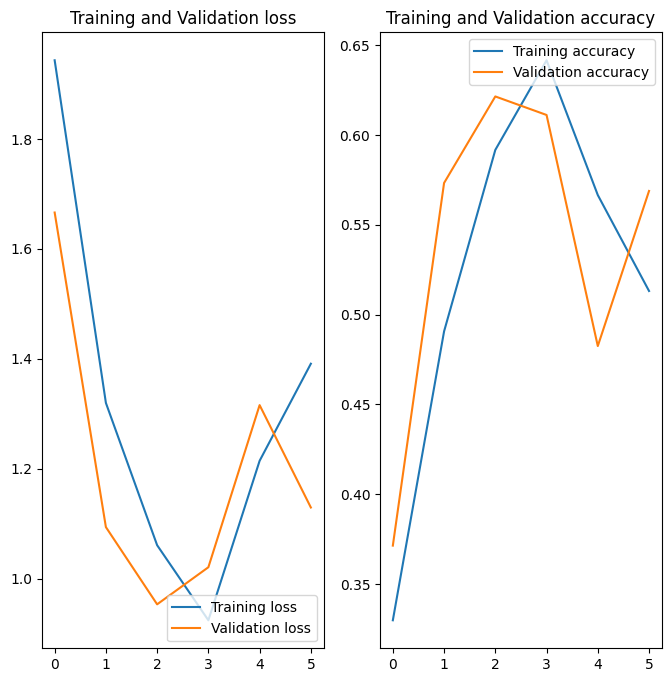

In [19]:
accuracy_loss_plot(history,model,model_name,save_dir)

##### plot and save confusion matrix on validation dataset

Computing confusion matrix for images, this may take a while...
Done!


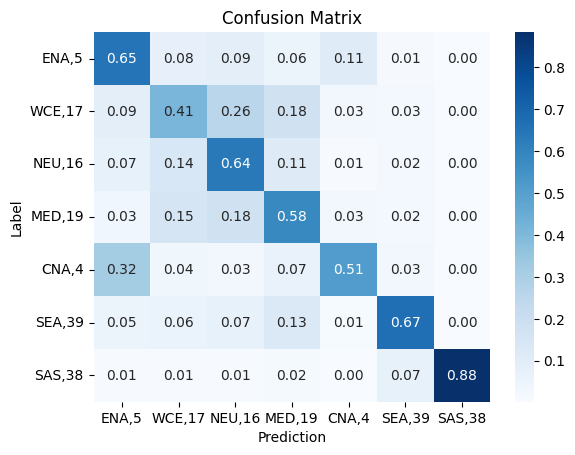

In [20]:
matrix_val = confusion_matrix(val_ds, model, num_classes)
confusion_matrix_plot(matrix_val, "row", name_dict, chosen_labels, model_name, save_dir)

##### plot and save confusion matrix on test dataset

Computing confusion matrix for images, this may take a while...
Done!


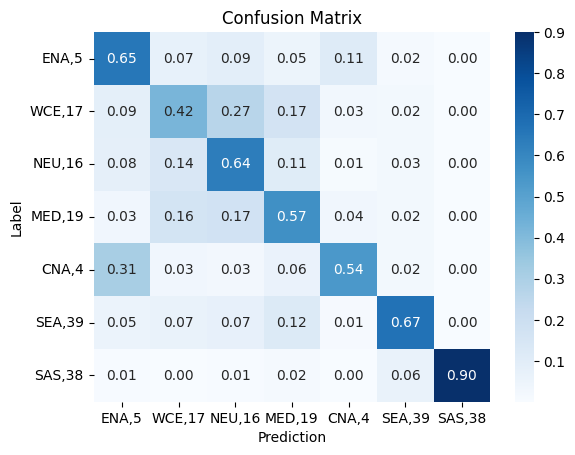

In [21]:
matrix_test = confusion_matrix(test_ds, model, num_classes)
confusion_matrix_plot(matrix_test, "row", name_dict, chosen_labels, model_name, save_dir)

##### save class metrics (accuracy, loss and f1score) on the test dataset

In [22]:
save_class_metrics(matrix_test,save_dir,model_name)